In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from matplotlib import pyplot

## NN

In [28]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))


## Activation Function (Sigmoid) and Loss Function

In [29]:
# activation function and its derivative
def sigmoid(x):
      return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size


## Layer

In [30]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError


## Activation Layer

In [31]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error


## Fully Connected Layer

In [32]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

## Create datasets using MNIST

In [33]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)
# same for test data : 10000 samples
x_test_n = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test_n = x_test_n.astype('float32')
x_test_n /= 255
y_test = np_utils.to_categorical(y_test)

# Our NN in Action!

In [34]:
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(sigmoid, sigmoid_prime))

net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=40, learning_rate=0.1)

# test
out = net.predict(x_test_n[0:1000])
# print("\n")
# print("predicted values : ")
# print(out, end="\n")
# print("true values : ")
# print(y_test[0:20])


epoch 1/40   error=0.095763
epoch 2/40   error=0.085761
epoch 3/40   error=0.081693
epoch 4/40   error=0.076880
epoch 5/40   error=0.071894
epoch 6/40   error=0.066877
epoch 7/40   error=0.061804
epoch 8/40   error=0.056853
epoch 9/40   error=0.052305
epoch 10/40   error=0.048295
epoch 11/40   error=0.044807
epoch 12/40   error=0.041772
epoch 13/40   error=0.039121
epoch 14/40   error=0.036792
epoch 15/40   error=0.034732
epoch 16/40   error=0.032895
epoch 17/40   error=0.031243
epoch 18/40   error=0.029747
epoch 19/40   error=0.028383
epoch 20/40   error=0.027134
epoch 21/40   error=0.025985
epoch 22/40   error=0.024923
epoch 23/40   error=0.023938
epoch 24/40   error=0.023023
epoch 25/40   error=0.022170
epoch 26/40   error=0.021372
epoch 27/40   error=0.020623
epoch 28/40   error=0.019920
epoch 29/40   error=0.019257
epoch 30/40   error=0.018631
epoch 31/40   error=0.018038
epoch 32/40   error=0.017475
epoch 33/40   error=0.016939
epoch 34/40   error=0.016429
epoch 35/40   error=0.0

## Actual vs. Predicted 

In [35]:
res=[]
for i in range(30):
    maxi=max(out[i][0])
    dx=list(out[i][0]).index(maxi)
    res.append(dx)


print("results:" ,res)
print("y-test: ",list(np.argmax(y_test[0:30],axis=1)))


results: [7, 2, 1, 0, 4, 1, 4, 9, 2, 9, 0, 2, 9, 0, 1, 5, 9, 7, 4, 4, 9, 6, 2, 5, 4, 0, 7, 4, 0, 1]
y-test:  [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1]


## Plot Actual vs. Predicted 

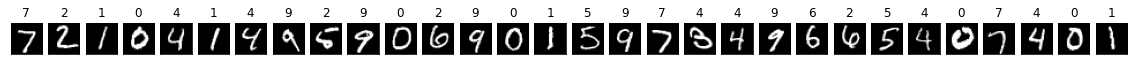

In [36]:
#plot predicted vs test
fig, axes = pyplot.subplots(ncols=len(res), sharex=False,
                         sharey=True, figsize=(20, 4))
for i in range(len(res)):
    axes[i].set_title(res[i],fontsize=12)
    axes[i].imshow(x_test[i], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
pyplot.show()
